In [14]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler , RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from matplotlib.ticker import MaxNLocator
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import os


# Importing custom functions
import sys
import os
root_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(root_path)

from baseline.functions import load_data,create_intervals,create_windows,smape

# Loss folder path images
loss_folder = 'C:/Users/criju/Documents/Cod-Thesis-2/neural_odes/loss-plots'
os.makedirs(loss_folder, exist_ok=True)

# Result folder path
result_folder = 'C:/Users/criju/Documents/Cod-Thesis-2/neural_odes/results'
os.makedirs(result_folder, exist_ok=True)


In [15]:
# Load the dataset
df = load_data('C:/Users/criju/Documents/Cod-Thesis-2/data/serie.csv')
df['Fecha'] = pd.to_datetime(df['Fecha'])

# Global variables
EPOCHS = 50 
BATCH_SIZE = 16    
HORIZONTE_1 = 15 
HORIZONTE_2 = 30
intervalos_ordenados = create_intervals(df)

In [16]:
# Neural ODE Model
class ODEFunc(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 1)
        )

    def forward(self, t, x):
        return self.net(x)

class NeuralODEModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.odefunc = ODEFunc()
    
    def forward(self, x):
        # x: [batch_size, seq_len, features]
        device = x.device
        seq_len = x.shape[1]
        # Crear t en el dispositivo correcto
        t = torch.linspace(0, 1, seq_len, device=device)
        # Estado inicial para cada muestra: último valor de la secuencia
        # Si features=1, x[:, -1, :] es [batch_size, 1]
        y0 = x[:, -1, :]
        # Integrar en batch: devuelve [len(t), batch_size, features]
        out = odeint(self.odefunc, y0, t, method='rk4')
        # Tomar el valor final en t=1 para cada muestra
        y_final = out[-1]
        return y_final  # forma [batch_size, features]


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Iteración 1: Mejor época = 46, Loss = 0.0187
Intervalos 1 a 1: MAE = 68.31, MSE = 6823.17


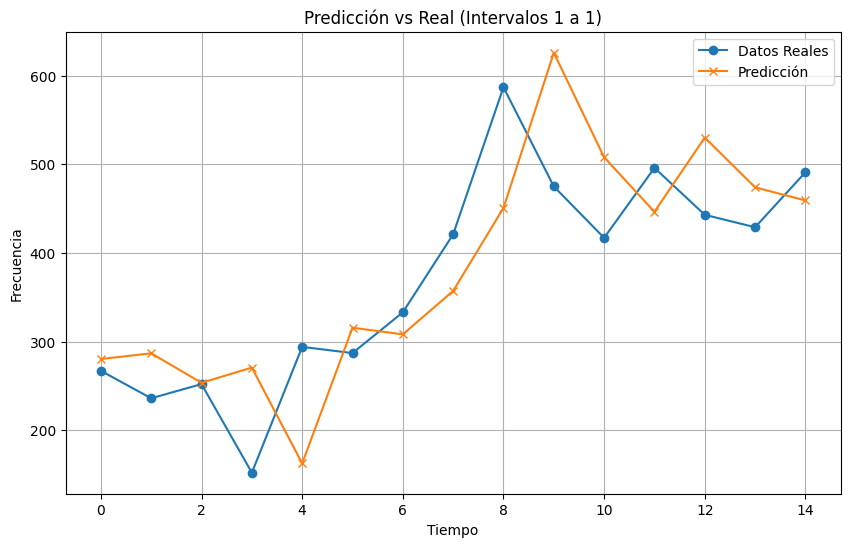

Iteración 2: Mejor época = 50, Loss = 0.0962
Intervalos 1 a 2: MAE = 109.46, MSE = 17757.12


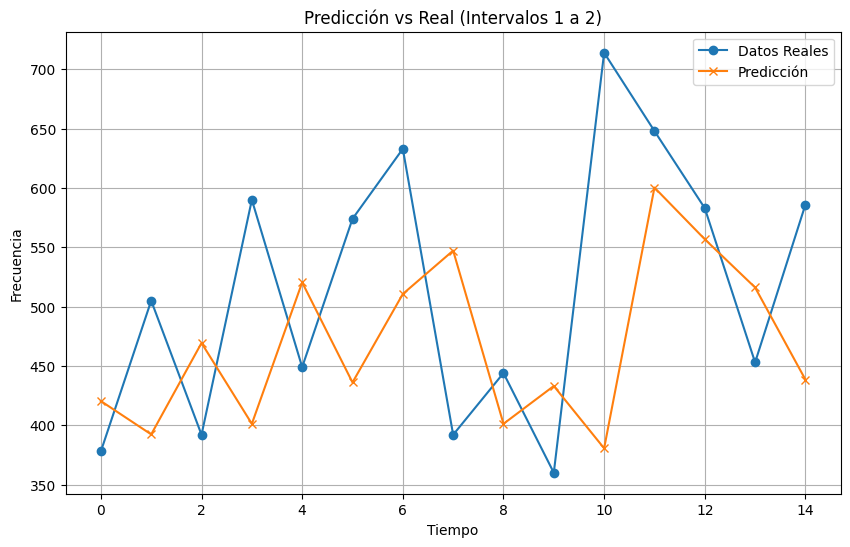

Iteración 3: Mejor época = 50, Loss = 0.0928
Intervalos 1 a 3: MAE = 232.12, MSE = 79840.98


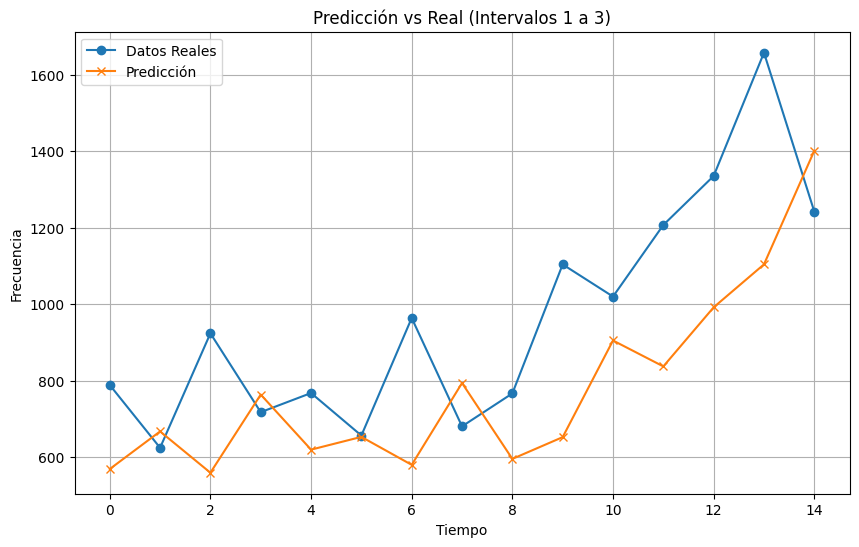

Iteración 4: Mejor época = 50, Loss = 0.0961
Intervalos 1 a 4: MAE = 12.15, MSE = 200.85


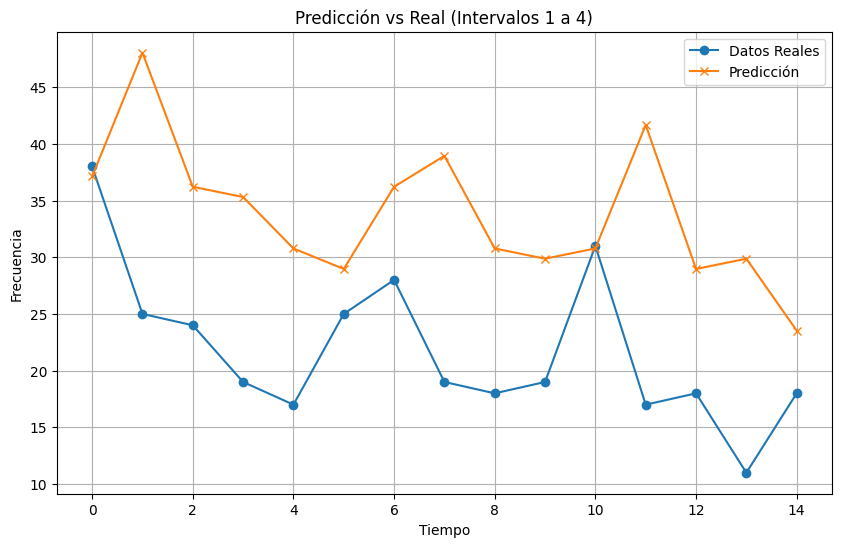

Iteración 5: Mejor época = 50, Loss = 0.0869
Intervalos 1 a 5: MAE = 60.05, MSE = 4759.11


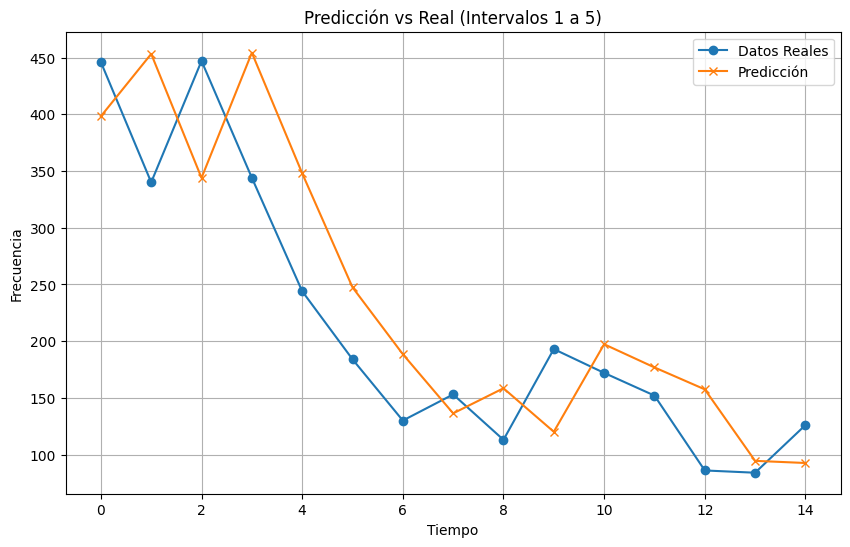

Iteración 6: Mejor época = 46, Loss = 0.0820
Intervalos 1 a 6: MAE = 19.97, MSE = 690.78


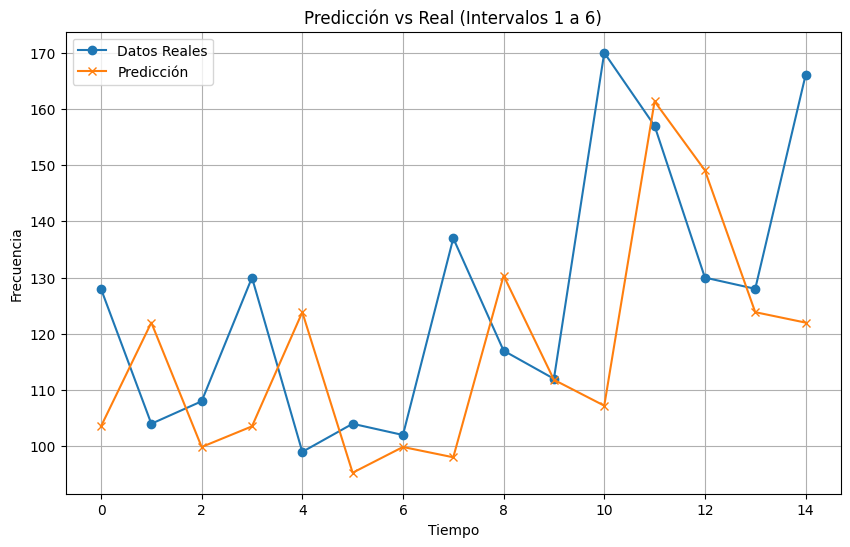

Iteración 7: Mejor época = 50, Loss = 0.0748
Intervalos 1 a 7: MAE = 11.37, MSE = 249.28


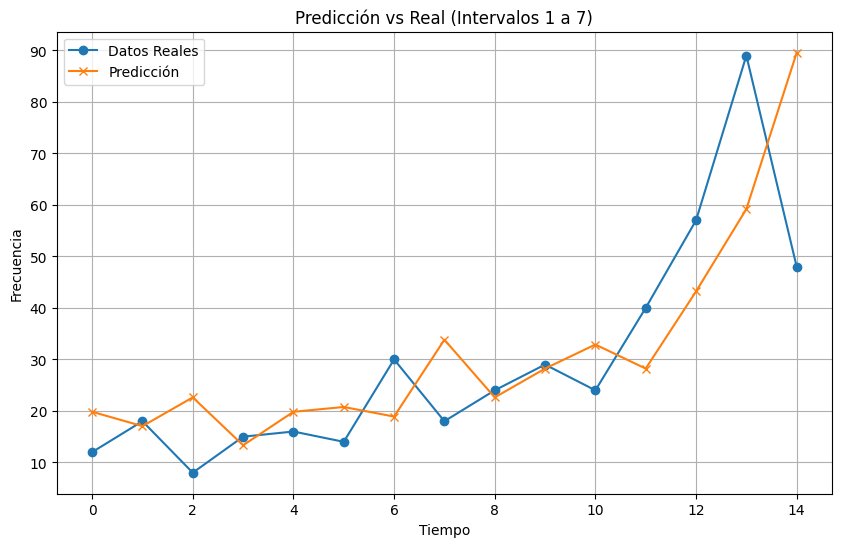

Iteración 8: Mejor época = 50, Loss = 0.0720
Intervalos 1 a 8: MAE = 3.66, MSE = 22.75


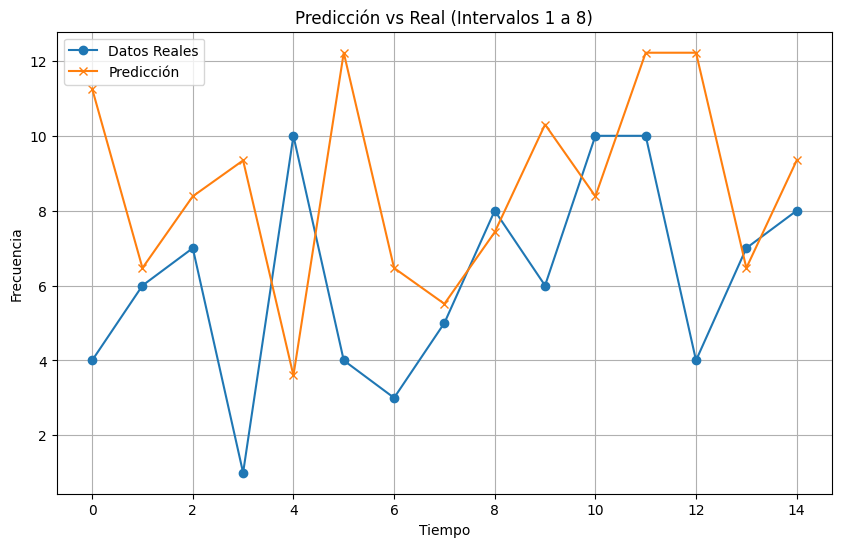


Resumen de métricas:
  Intervalos Acumulados         MAE           MSE      SMAPE
0      Intervalos 1 a 1   68.308861   6823.173828  19.381301
1      Intervalos 1 a 2  109.464188  17757.123047  22.121705
2      Intervalos 1 a 3  232.119766  79840.984375  25.810325
3      Intervalos 1 a 4   12.147094    200.848740  45.341462
4      Intervalos 1 a 5   60.047386   4759.114746  27.747372
5      Intervalos 1 a 6   19.973763    690.776733  16.024438
6      Intervalos 1 a 7   11.373175    249.283829  35.423872
7      Intervalos 1 a 8    3.657388     22.753050  52.199870


In [17]:
WINDOW_SIZE = 7  
resultados = []

for i in range(len(intervalos_ordenados)):

    scaler = StandardScaler()

    # Tomando intervalo por intervalo
    intervalos_incluir = intervalos_ordenados[:i+1]
    df_accu = df[df['Intervalo'].isin(intervalos_incluir)]
    df_accu = df_accu.sort_values(by='Fecha')
    series = df_accu['Frecuencia'].values.reshape(-1, 1)

    # Normalizar los datos
    series_scaled = scaler.fit_transform(series)
    X,y = create_windows(series_scaled, window_size=WINDOW_SIZE)
    X_train , y_train = X[:-HORIZONTE_1], y[:-HORIZONTE_1]
    X_test , y_test = X[-HORIZONTE_1:], y[-HORIZONTE_1:]

    X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
    X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

    model = NeuralODEModel().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.MSELoss()

    loss_vals = []
    for epoch in range(EPOCHS):
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
        loss_vals.append(loss.item())

    best_epoch = int(np.argmin(loss_vals)) + 1
    best_loss = loss_vals[best_epoch - 1]
    print(f"Iteración {i+1}: Mejor época = {best_epoch}, Loss = {best_loss:.4f}")

    # Plot de pérdida
    fig = plt.figure(figsize=(8,5))
    ax = fig.gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    ax.plot(range(1, EPOCHS + 1), loss_vals, marker='o')
    ax.axvline(best_epoch, color='gray', linestyle='--', label=f"Best epoch ({best_epoch})")
    ax.set_xlabel("Época")
    ax.set_ylabel("Loss")
    ax.set_title(f"Entrenamiento Intervalos 1 a {i+1}")
    ax.grid(True)
    ax.legend()

    # Asegúrate de crear la carpeta antes:
    subfolder_path = os.path.join(loss_folder, "neural_loss_7_15")
    os.makedirs(subfolder_path, exist_ok=True)
    plot_path = os.path.join(subfolder_path, f"neural_ode_loss_{i+1}.png")

    # Guarda la figura ANTES de cerrar:
    fig.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.close(fig)  # cierra la figura después de guardar


    # Evaluación
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test).cpu().numpy()  # [batch_test, 1]
    y_pred_inv = scaler.inverse_transform(y_pred)
    y_test_inv = scaler.inverse_transform(y_test.cpu().numpy().reshape(-1,1))
    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    mse = mean_squared_error(y_test_inv, y_pred_inv)
    smape_value = smape(y_test_inv, y_pred_inv)
    resultados.append({
        'Intervalos Acumulados': f"Intervalos 1 a {i+1}",
        'MAE': mae,
        'MSE': mse,
        'SMAPE': smape_value
    })
    print(f"Intervalos 1 a {i+1}: MAE = {mae:.2f}, MSE = {mse:.2f}")

    plt.figure(figsize=(10, 6))
    plt.plot(y_test_inv, label="Datos Reales", marker='o')
    plt.plot(y_pred_inv, label="Predicción", marker='x')
    plt.title(f"Predicción vs Real (Intervalos 1 a {i+1})")
    plt.xlabel("Tiempo")
    plt.ylabel("Frecuencia")
    plt.legend()
    plt.grid(True)
    plt.show()

df_resultados = pd.DataFrame(resultados)
print("\nResumen de métricas:")
print(df_resultados) 


subfolder1_path = os.path.join(result_folder, "neural_results_15")
os.makedirs(subfolder1_path, exist_ok=True)


# Ruta completa al archivo dentro de la subcarpeta
csv_path = os.path.join(subfolder1_path, "resultados_neural_ode_15.csv")

# Guardar el DataFrame en esa ruta
df_resultados.to_csv(csv_path, index=False)

Iteración 1: Mejor época = 42, Loss = 0.0036
Intervalos 1 a 1: MAE = 49.72, MSE = 4368.89


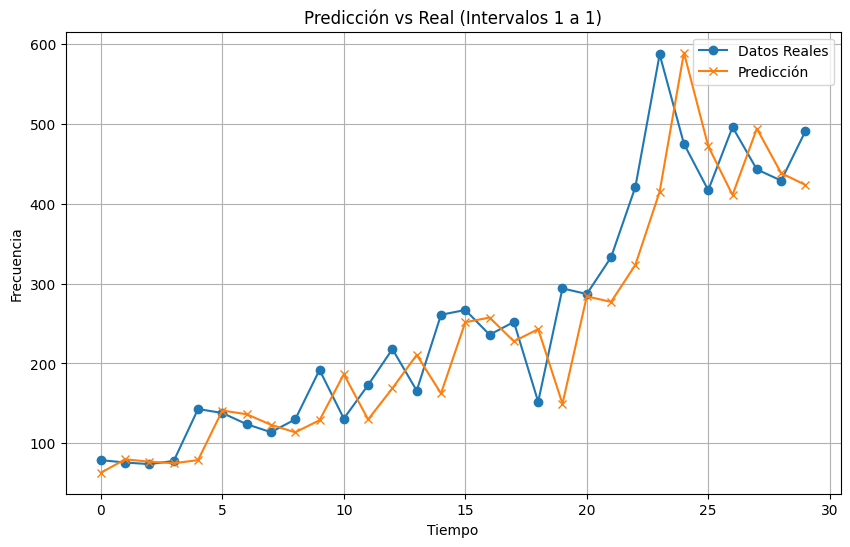

Iteración 2: Mejor época = 50, Loss = 0.0910
Intervalos 1 a 2: MAE = 91.84, MSE = 12388.50


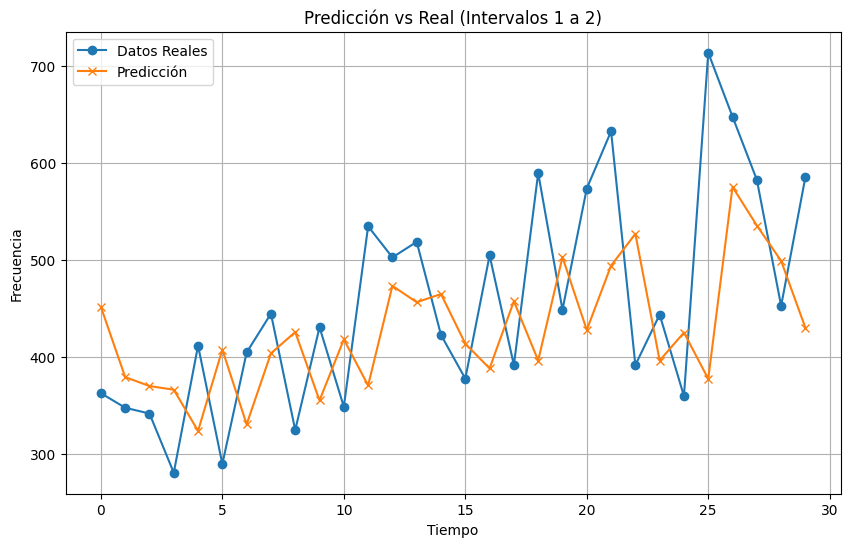

Iteración 3: Mejor época = 50, Loss = 0.0837
Intervalos 1 a 3: MAE = 178.05, MSE = 49733.73


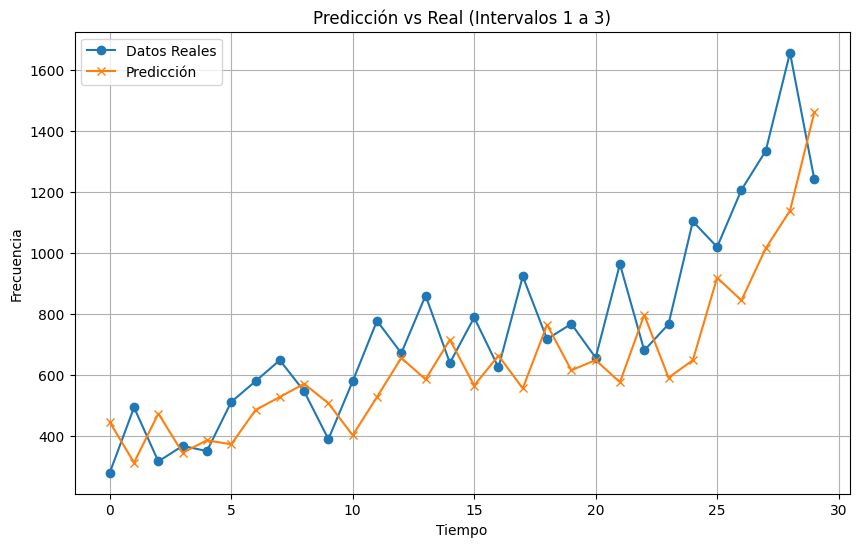

Iteración 4: Mejor época = 46, Loss = 0.0985
Intervalos 1 a 4: MAE = 8.51, MSE = 109.83


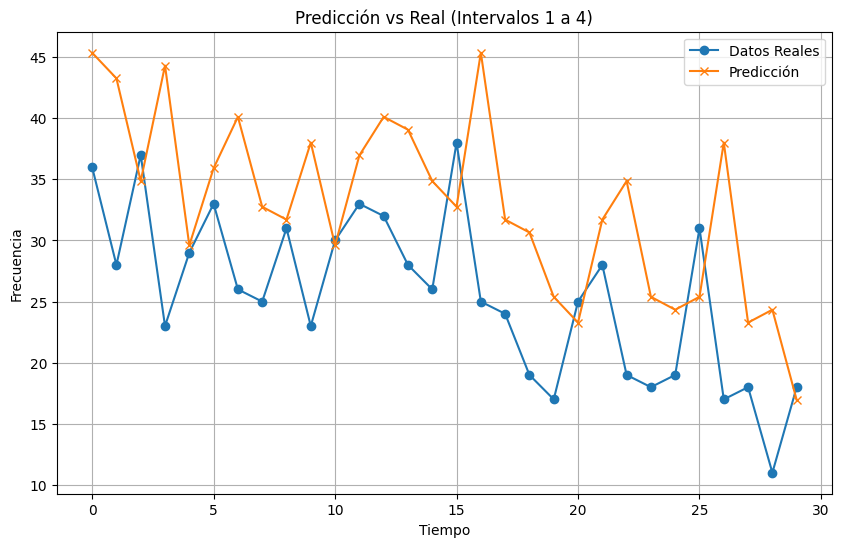

Iteración 5: Mejor época = 50, Loss = 0.0845
Intervalos 1 a 5: MAE = 110.42, MSE = 21977.86


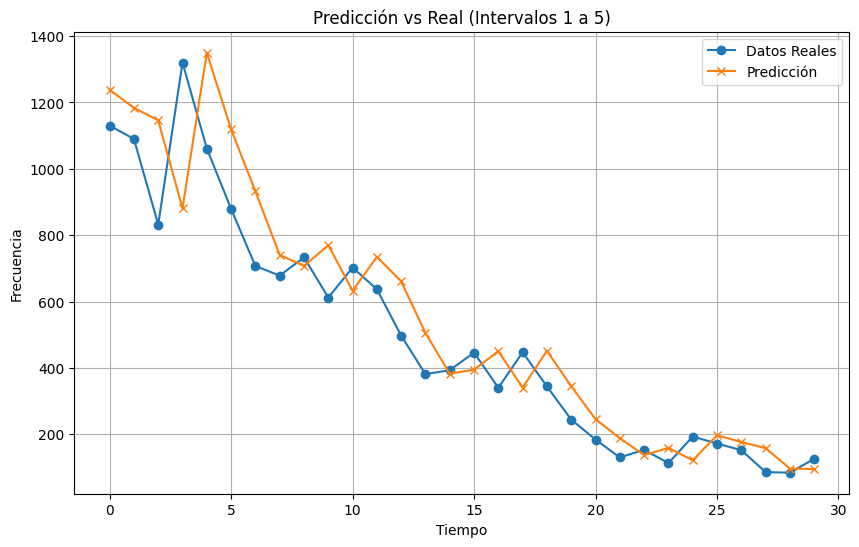

Iteración 6: Mejor época = 50, Loss = 0.0826
Intervalos 1 a 6: MAE = 18.60, MSE = 541.34


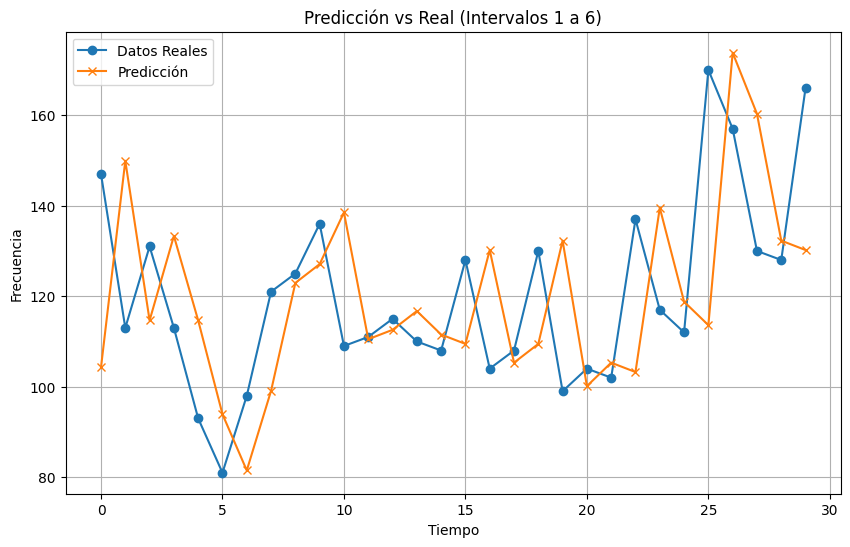

Iteración 7: Mejor época = 48, Loss = 0.0767
Intervalos 1 a 7: MAE = 7.63, MSE = 136.74


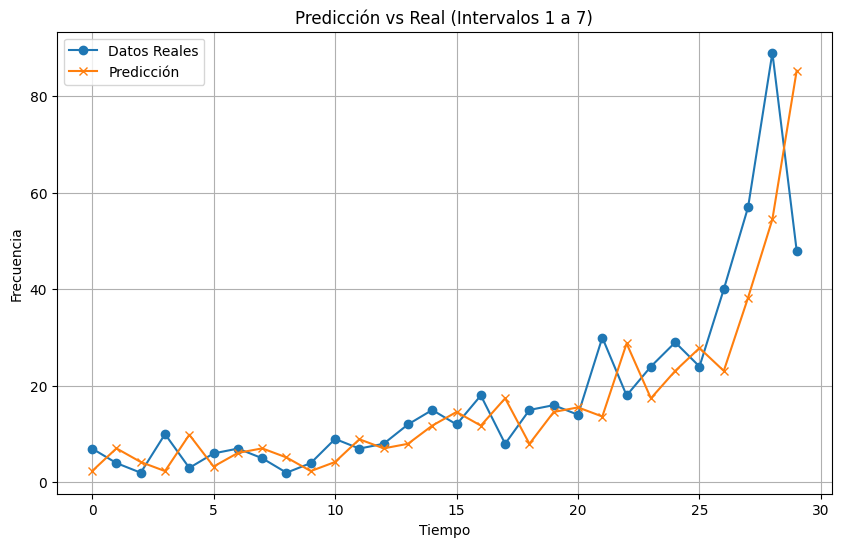

Iteración 8: Mejor época = 48, Loss = 0.0742
Intervalos 1 a 8: MAE = 10.23, MSE = 119.57


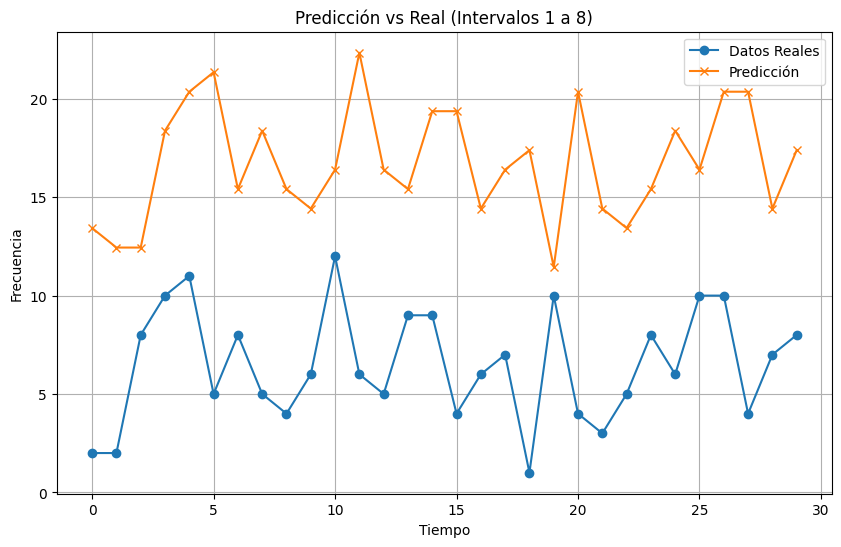


Resumen de métricas:
  Intervalos Acumulados         MAE           MSE      SMAPE
0      Intervalos 1 a 1   49.722836   4368.888184  20.676340
1      Intervalos 1 a 2   91.841438  12388.504883  20.518136
2      Intervalos 1 a 3  178.047195  49733.726562  25.341728
3      Intervalos 1 a 4    8.507710    109.832367  29.709402
4      Intervalos 1 a 5  110.421806  21977.855469  23.205739
5      Intervalos 1 a 6   18.600401    541.338135  15.101844
6      Intervalos 1 a 7    7.630982    136.738861  49.368051
7      Intervalos 1 a 8   10.229742    119.565323  91.249293


In [18]:
WINDOW_SIZE = 7  
resultados = []

for i in range(len(intervalos_ordenados)):

    scaler = StandardScaler()

    # Tomando intervalo por intervalo
    intervalos_incluir = intervalos_ordenados[:i+1]
    df_accu = df[df['Intervalo'].isin(intervalos_incluir)]
    df_accu = df_accu.sort_values(by='Fecha')
    series = df_accu['Frecuencia'].values.reshape(-1, 1)

    # Normalizar los datos
    series_scaled = scaler.fit_transform(series)
    X,y = create_windows(series_scaled, window_size=WINDOW_SIZE)
    X_train , y_train = X[:-HORIZONTE_2], y[:-HORIZONTE_2]
    X_test , y_test = X[-HORIZONTE_2:], y[-HORIZONTE_2:]

    X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
    X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

    model = NeuralODEModel().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.MSELoss()

    loss_vals = []
    for epoch in range(EPOCHS):
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
        loss_vals.append(loss.item())

    best_epoch = int(np.argmin(loss_vals)) + 1
    best_loss = loss_vals[best_epoch - 1]
    print(f"Iteración {i+1}: Mejor época = {best_epoch}, Loss = {best_loss:.4f}")

    # Plot de pérdida
    fig = plt.figure(figsize=(8,5))
    ax = fig.gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    ax.plot(range(1, EPOCHS + 1), loss_vals, marker='o')
    ax.axvline(best_epoch, color='gray', linestyle='--', label=f"Best epoch ({best_epoch})")
    ax.set_xlabel("Época")
    ax.set_ylabel("Loss")
    ax.set_title(f"Entrenamiento Intervalos 1 a {i+1}")
    ax.grid(True)
    ax.legend()

    # Asegúrate de crear la carpeta antes:
    subfolder_path = os.path.join(loss_folder, "neural_loss_7_30")
    os.makedirs(subfolder_path, exist_ok=True)
    plot_path = os.path.join(subfolder_path, f"neural_ode_loss_{i+1}.png")

    # Guarda la figura ANTES de cerrar:
    fig.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.close(fig)  # cierra la figura después de guardar


    # Evaluación
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test).cpu().numpy()  # [batch_test, 1]
    y_pred_inv = scaler.inverse_transform(y_pred)
    y_test_inv = scaler.inverse_transform(y_test.cpu().numpy().reshape(-1,1))
    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    mse = mean_squared_error(y_test_inv, y_pred_inv)
    smape_value = smape(y_test_inv, y_pred_inv)
    resultados.append({
        'Intervalos Acumulados': f"Intervalos 1 a {i+1}",
        'MAE': mae,
        'MSE': mse,
        'SMAPE': smape_value
    })
    print(f"Intervalos 1 a {i+1}: MAE = {mae:.2f}, MSE = {mse:.2f}")

    plt.figure(figsize=(10, 6))
    plt.plot(y_test_inv, label="Datos Reales", marker='o')
    plt.plot(y_pred_inv, label="Predicción", marker='x')
    plt.title(f"Predicción vs Real (Intervalos 1 a {i+1})")
    plt.xlabel("Tiempo")
    plt.ylabel("Frecuencia")
    plt.legend()
    plt.grid(True)
    plt.show()

df_resultados = pd.DataFrame(resultados)
print("\nResumen de métricas:")
print(df_resultados) 


subfolder1_path = os.path.join(result_folder, "neural_results_30")
os.makedirs(subfolder1_path, exist_ok=True)


# Ruta completa al archivo dentro de la subcarpeta
csv_path = os.path.join(subfolder1_path, "resultados_neural_ode_30.csv")

# Guardar el DataFrame en esa ruta
df_resultados.to_csv(csv_path, index=False)